In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions  = readTextFile("new.txt")
captions = captions.split('\n')[:-1]

In [ ]:
print(len(captions))
print(captions[4])

40456
1000268201_693b08cb0e.jpg##A little girl climbing the stairs to her playhouse .


In [ ]:
first,second  = captions[0].split('##')
print(first.split(".")[0])
print(second)

image
caption


In [ ]:

descriptions = {}

for x in captions:
    first,second = x.split('##')
    img_name = first.split(".")[0]

    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [ ]:
first,second = captions[100].split("##")
print(first.split("."))


['102351840_323e3de834', 'jpg']


In [ ]:
descriptions["1112212364_0c48235fc2"]

['A baby is sitting on and playing with smooth rocks .',
 'A baby is stacking rocks on the beach .',
 'A small boy is playing with rocks',
 'A toddler sitting on a pile of rocks holding a rock at a beach .',
 'Toddler sits on a pile of rocks .']

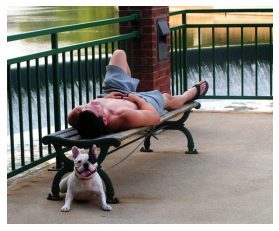

In [ ]:
IMG_PATH = "dataset/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1003163366_44323f5815.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Cleaning

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [ ]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["27782020_4dab210360"]

['brightly decorated bicycle with cart with people walking around in the background',
 'street vending machine is parked while people walk by',
 'street vendor on the corner of busy intersection',
 'people on the city street walk past puppet theater',
 'people walk around mobile puppet theater in big city']

In [ ]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

## Vocabulary

In [ ]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8425


In [ ]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373804


In [ ]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8425


In [ ]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words))

1845


## Prepare Train/Test Data

In [ ]:
train_file_data = readTextFile("train7.txt")
test_file_data = readTextFile("test1.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1002674143_1b742ab4b8"]

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

# Transfer Learning

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


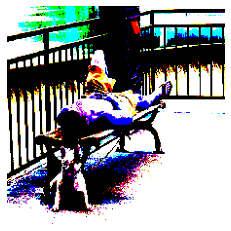

In [ ]:
img = preprocess_img(IMG_PATH+"1003163366_44323f5815.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encode_image(IMG_PATH+"1003163366_44323f5815.jpg")

array([0.1387394 , 0.13371012, 0.21037503, ..., 0.31287536, 0.43861842,
       0.58648366], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image  

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
with open("encoded_train_features_new.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 240.2613980770111


In [ ]:
with open("encoded_test_features_new.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## Data pre-processing for Captions

In [ ]:
# Vocab
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [ ]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [ ]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


## Data Loader (Generator)

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

# Word Embeddings

In [ ]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [ ]:
f.close()

In [ ]:
embedding_index['mountain']

array([ 0.44469  ,  1.7411   ,  0.24895  ,  0.30172  , -0.60967  ,
       -0.64624  , -1.2097   , -0.16842  ,  0.44635  , -1.2397   ,
       -0.42442  , -0.92472  ,  0.68919  , -0.29421  , -0.70245  ,
        0.65651  ,  1.0121   ,  0.66883  , -1.3459   , -0.31857  ,
       -0.94914  , -0.022777 , -0.0096754,  0.71226  ,  0.36824  ,
       -0.7096   , -1.2219   ,  0.77468  ,  0.03788  , -0.046706 ,
        2.3723   , -0.80034  , -0.76385  ,  0.41145  ,  0.78734  ,
       -0.17004  , -0.9871   , -0.62722  ,  0.28548  ,  0.024311 ,
       -0.56093  , -0.044454 ,  0.17004  , -0.052555 ,  0.32851  ,
       -0.4362   ,  1.0471   , -1.1037   ,  0.0058918, -0.86151  ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [ ]:
embedding_matrix[1800]

array([-0.19212 ,  0.58991 , -0.016453,  0.55384 ,  0.65911 ,  1.0316  ,
       -0.55807 , -0.78602 ,  0.59405 , -0.73028 ,  0.063776,  0.3531  ,
        0.7123  , -0.38352 , -0.14271 , -0.077119, -0.37528 ,  0.41887 ,
       -0.25573 , -1.3098  , -0.98415 , -1.9577  ,  0.97034 , -0.36311 ,
       -0.44061 , -0.23878 ,  0.43531 ,  1.4808  ,  0.65945 , -0.78764 ,
        1.7215  , -0.43166 ,  0.070071, -0.05738 , -0.082677,  0.61642 ,
       -0.50708 ,  0.12888 ,  0.56509 , -0.68641 ,  0.10125 , -0.63011 ,
       -0.90007 , -0.092616,  1.1439  ,  0.22071 ,  0.68059 , -0.45281 ,
       -0.26077 , -0.64546 ])

## Model Architecture


In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

## Training of Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)#number_pics_per_batch

In [ ]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        tf.keras.models.save_model(to_file='model_'+str(i)+'.h5')
        model.compile(optimizer='sgd',
            loss='mse',
              metrics=[tf.keras.metrics.Accuracy()])

In [ ]:
model = load_model('model_9.h5')

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

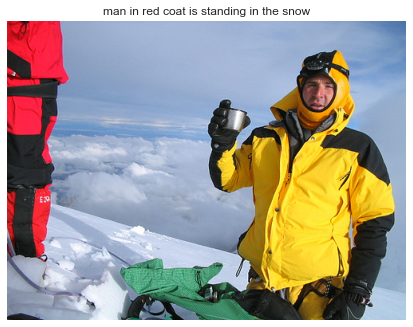

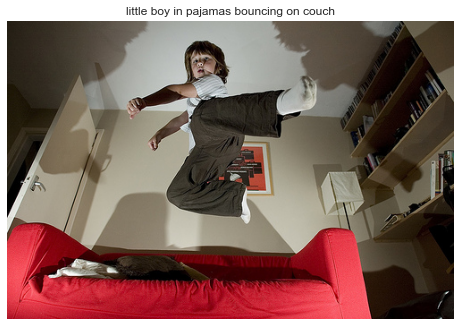

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(2):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("dataset/Images/"+img_name+".jpg")
    
    
    caption = predict_caption(photo_2048)

    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    

## Text to Voice Concept 

In [ ]:
!pip install gTTS

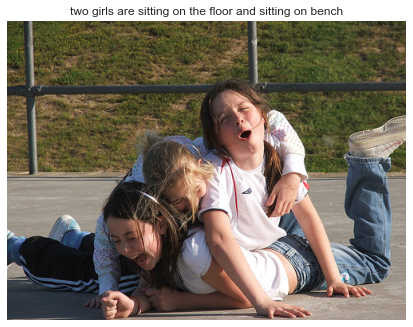

In [ ]:
from gtts import gTTS
plt.style.use("seaborn")
idx = np.random.randint(0,1000)
all_img_names = list(encoding_test.keys())
img_name = all_img_names[idx]
photo_2048 = encoding_test[img_name].reshape((1,2048))
    
i = plt.imread("dataset/Images/"+img_name+".jpg")
    
    
desc = predict_caption(photo_2048)

    
plt.title(desc)
plt.imshow(i)
plt.axis("off")
plt.show()
text_to_say= desc

language = "en"

gtts_object = gTTS(text = text_to_say, 
                  lang = language,
                  slow = False)

gtts_object.save("dataset/something.wav")
# this is for saving audio file on Google collab

from IPython.display import Audio

Audio("dataset/something.wav")